# 2D Acoustic Wave Equation
---

Consider the 2d acoustic wave equation
$$
\begin{aligned}
&\frac{\partial^2 p}{\partial t^2} = c^2(x, z)\left(\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial z^2}\right) + \frac{\partial}{\partial t}f(x, z, t) \\
\end{aligned}
$$
where $p$ is Pressure, $c$ is Medium Velocity. The source term $f$ is represented by a Ricker wavelet (practically, we regard it as a multiplication of Ricker wavelet in temporal domain with Gaussian dissolve in the spatial domain)
$$
f(x, z, t) = R(t)N(x, z),
$$
where
$$
R(t) = \left(1-2(\pi f_0(t-t_0))^2\right)\exp\left(-(\pi f_0(t-t_0))^2\right),
$$
where $f_0 = 20$ is the dominant frequency, $t_0 = 0.05$ is time delay, and
$$
N(x, z) = \exp\left(-\frac{1}{\alpha^2}\left((x-x_s)^2+(z-z_s)^2\right)\right).
$$

---

**We need to notice that there is a $\frac{\partial}{\partial t}$ in this second-order equation. This comes from converting the first-order equation to second-order**.

Hence, 
$$
\frac{\partial}{\partial t}f(x, z, t) = -2A^2(t-t_0)(3-2A^2(t-t_0)^2)e^{-A^2(t-t_0)^2},
$$
where $A = \pi f_0$.

---

## Data

- $p$: Pressure

- All known data are collected in the spatial domain $(x, z) \in [1, 500]\times [1, 500]$, with grid size 10 (which means the spatial grids are {10, 20, ..., 500}. The temporal domain is $t\in [0, 0.5)$, with time step $dt = 0.01$. This gives 50 time steps as recorded, i.e., $t = \{0, 0.01, \cdots, 0.49\}$.

- The sources are located at $(x_s, z_s) = \{50, 100, \cdots, 450\} \times \{10\}$.

## Target
- Recover the direct problem $p$
- Recover the inverse problem $c$

## Scaling (A simple substitution of variables)

We let
$$
x' = \frac{x}{x_0}, \ z' = \frac{z}{z_0}, \ t' = \frac{t}{t_0}, \ u' = \frac{u}{u_0}, \ c' = \frac{c}{c_0},
$$
where $x_0, z_0, t_0, u_0, c_0$ are scaling constants to be determined. Then the equation becomes
$$
\frac{p_0}{t_0^2}\frac{\partial^2 p'}{\partial t'^2} = c_0^2c'(x_0x', z_0z')\left(\frac{p_0}{x_0^2}\frac{\partial^2 p'}{\partial x'^2} + \frac{p_0}{z_0^2}\frac{\partial^2 p'}{\partial z'^2}\right) + f(x_0x', z_0z', t_0t').
$$

In this case, we let
$$
x_0 = z_0 = c_0 = 1000, \ t_0 = 1, \ p_0 = 1,
$$

---

## Initialize inverse model:

- add bias (close to true value) to the last layer of inverse model

---

## Simplify the problem

We first consider $c(x, z)$ is independent of $x$, i.e,  $c(x, z) = c(z)$.

In [1]:
NAME = "0630_0704_1_direct_model_siren_weighted_loss"

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("../../")
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")

%load_ext autoreload
%autoreload 2

In [3]:
def setup_model(layers, c, w0, lambda_1, adaptive = None):
	class scaled_dense(keras.layers.Layer):
		def __init__(self, units, input_dim, c, w0, lambda_1):
			super(scaled_dense, self).__init__()
			self.lambda_1 = lambda_1
			w_init = tf.random_uniform_initializer(-np.sqrt(c/input_dim), np.sqrt(c/input_dim))
			self.w = tf.Variable(initial_value = w_init(shape = (input_dim, units), dtype = "float32"), trainable = True)
			b_init = tf.zeros_initializer()
			self.b = tf.Variable(initial_value = b_init(shape=(units,), dtype="float32"), trainable=True)
			self.w0 = tf.Variable(w0, dtype = "float32", trainable = True)
			
		def call(self, inputs):
			self.add_loss(self.lambda_1*tf.reduce_sum(tf.abs(self.w)))
			return tf.sin(tf.matmul(inputs, self.w)*self.w0 + self.b)
	
	with tf.device("/device:GPU:0"):
		model = keras.models.Sequential()
		if adaptive == "first" or adaptive == "all":
			model.add(scaled_dense(layers[1], layers[0], c, w0, lambda_1))
		else:
			model.add(keras.layers.Dense(layers[1], input_shape = (layers[0], ), activation = K.sin,
										kernel_initializer = keras.initializers.RandomUniform(-w0*np.sqrt(c/layers[0]), w0*np.sqrt(c/layers[0])),
										kernel_regularizer = keras.regularizers.l1(lambda_1)))
		for i in range(1, len(layers)-2):
			if adaptive == "all":
				model.add(scaled_dense(layers[i+1], layers[i], c, 1.0, lambda_1))
			else:
				model.add(keras.layers.Dense(layers[i+1], input_shape = (layers[i], ), activation = K.sin,
									kernel_initializer = keras.initializers.RandomUniform(-np.sqrt(c/layers[i]), np.sqrt(c/layers[i])),
									kernel_regularizer = keras.regularizers.l1(lambda_1)))
		model.add(keras.layers.Dense(layers[-1]))
	return model

def generate_model(layers, adaptive = None, bias = None):
	class adaptive_dense(keras.layers.Layer):
		def __init__(self, units, input_dim):
			super(adaptive_dense, self).__init__()
			w_init = keras.initializers.GlorotUniform()
			self.w = tf.Variable(initial_value = w_init(shape = (input_dim, units), dtype = "float32"), trainable = True)
			b_init = tf.zeros_initializer()
			self.b = tf.Variable(initial_value = b_init(shape=(units,), dtype="float32"), trainable=True)
			self.a = tf.Variable(1.0, dtype = "float32", trainable = True)
			
		def call(self, inputs):
			return tf.tanh(self.a*(tf.matmul(inputs, self.w) + self.b))
	
	with tf.device("/device:GPU:0"):
		model = keras.models.Sequential()
		if adaptive == "first" or adaptive == "all":
			model.add(adaptive_dense(layers[1], layers[0]))
		else:
			model.add(keras.layers.Dense(layers[1], input_shape = (layers[0], ), activation = "tanh"))
		for i in range(1, len(layers)-2):
			if adaptive == "all":
				model.add(adaptive_dense(layers[i+1], layers[i]))
			else:
				model.add(keras.layers.Dense(layers[i+1], input_shape = (layers[i], ), activation = "tanh"))
		if bias:
			model.add(keras.layers.Dense(layers[-1], bias_initializer = keras.initializers.Constant(bias)))
		else:
			model.add(keras.layers.Dense(layers[-1]))
	return model

# w0 = 100
# c = 6
# lambda_1 = 0.5

# direct_layers = [4, 128, 128, 128, 128, 1] # (x, z, t, xs) -> p
# direct_model = setup_model(direct_layers, c, w0, lambda_1)

inverse_layers = [1, 32, 32, 1] # (z) -> (c)
inverse_bias = 2.0
inverse_model = generate_model(inverse_layers, True, inverse_bias)

In [4]:
i = 3
direct_model = keras.models.load_model("models/{}/{}_adam/direct_model".format(NAME, i))

In [6]:
x0, z0, t0 = 1e3, 1e3, 1.0
p0, c0 = 1.0, 1e3

In [6]:
# source
f_0 = 20.0
A = f_0*np.pi
alpha = 2.0*10 # multiplied by dx
M0 = 1 # scale p

# actually, it's dR/dt
@tf.function
def R(t, t_s):
	return M0*(-2*A**2)*(t-t_s)*(3-2*(A*(t-t_s))**2)*tf.exp(-(A*(t-t_s))**2)

@tf.function
def N(x, z, x_s, z_s):
	return tf.exp(-1.0/(alpha**2) * ((x-x_s)**2 + (z-z_s)**2))

# actually, it's df/dt
@tf.function
def f(x, z, t, x_s, z_s, t_s):
	return R(t, t_s)*N(x, z, x_s, z_s)

In [7]:
w_zero = 1e-2
threshold = 1e-3

def weighted_loss(true, pred):
	error = K.square(true - pred)
	error = K.mean(K.switch(K.less_equal(K.abs(true), threshold), w_zero * error , error))
	return error 

In [28]:
loss_func = keras.losses.MeanSquaredError()
loss_func_r = keras.losses.MeanAbsoluteError() # l1 loss

def get_residue_loss(tape, p, c, x, z, t, x_s, z_s, t_s):
	dp_dt = tape.gradient(p, t)
	dp_dtt = tape.gradient(dp_dt, t)
	dp_dx = tape.gradient(p, x)
	dp_dxx = tape.gradient(dp_dx, x)
	dp_dz = tape.gradient(p, z)
	dp_dzz = tape.gradient(dp_dz, z)
# 	tf.print(p_dtt, dp_dxx, dp_dzz)
	eq1 = loss_func_r(p0/(t0**2)*dp_dtt, c0**2*tf.square(c)*(p0/(x0**2)*dp_dxx + p0/(z0**2)*dp_dzz) + f(x0*x, z0*z, t0*t, x0*x_s, z0*z_s, t0*t_s))
	return eq1

def step(data_sources, residue = True):
	losses = []
	with tf.GradientTape(persistent = True) as tape:
		tape.watch([x for d in data_sources for x in d])
		for data in data_sources:
			[x_c, z_c, t_c, x_s_c, z_s_c, t_s_c,
			 x_i, z_i, t_i, p_i, x_s_i, z_s_i, t_s_i,
			 x_d, z_d, t_d, p_d, x_s_d, z_s_d, t_s_d] = data
			if residue:
				out_c = direct_model(tf.concat([x_c, z_c, t_c, x_s_c], axis = 1))
# 				c_c = inverse_model(tf.concat([x_c, z_c], axis = 1))
				c_c = inverse_model(z_c)
				out_d = direct_model(tf.concat([x_d, z_d, t_d, x_s_d], axis = 1))
# 				c_d = inverse_model(tf.concat([x_d, z_d], axis = 1))
				c_d = inverse_model(z_d)
				out_i = direct_model(tf.concat([x_i, z_i, t_i, x_s_i], axis = 1))
# 				c_i = inverse_model(tf.concat([x_i, z_i], axis = 1))
				c_i = inverse_model(z_i)
				loss_c = get_residue_loss(tape, out_c, c_c, x_c, z_c, t_c, x_s_c, z_s_c, t_s_c)
				loss_dr = get_residue_loss(tape, out_d, c_d, x_d, z_d, t_d, x_s_d, z_s_d, t_s_d)
				loss_dv = weighted_loss(out_d, p_d)
				loss_ir = get_residue_loss(tape, out_i, c_i, x_i, z_i, t_i, x_s_i, z_s_i, t_s_i)
				loss_iv = loss_func(out_i, p_i)
			else:
				out_d = direct_model(tf.concat([x_d, z_d, t_d, x_s_d], axis = 1))
				out_i = direct_model(tf.concat([x_i, z_i, t_i, x_s_i], axis = 1))
				loss_c = 0
				loss_dr = 0
				loss_ir = 0
				loss_dv = weighted_loss(out_d, p_d)
				loss_iv = loss_func(out_i, p_i)
			losses.append([loss_c, loss_dr, loss_dv, loss_ir, loss_iv])

		loss_c = sum([l[0] for l in losses])
		loss_dr = sum([l[1] for l in losses])
		loss_dv = sum([l[2] for l in losses])
		loss_ir = sum([l[3] for l in losses])
		loss_iv = sum([l[4] for l in losses])
		loss = w_c*loss_c + w_dr*loss_dr + w_dv*loss_dv + w_ir*loss_ir + w_iv*loss_iv
	
	grads_direct = tape.gradient(loss, direct_model.trainable_variables)
	optimizer_direct.apply_gradients(zip(grads_direct, direct_model.trainable_variables))
	
	if residue:
		grads_inverse = tape.gradient(loss, inverse_model.trainable_variables)
		optimizer_inverse.apply_gradients(zip(grads_inverse, inverse_model.trainable_variables))
	
	del tape
	return loss, loss_c, loss_dr, loss_dv, loss_ir, loss_iv


def train(residue, data_sources, epochs, batch_proportion = 0.1, print_every = 100, save_every = 10000, save_path = None):
	shuffled = lambda dataset: [tf.data.Dataset.from_tensor_slices(tuple(d)).shuffle(buffer_size = max(d[0].shape[0], 1), \
                                                        reshuffle_each_iteration = True).batch(max(int(batch_proportion*d[0].shape[0]), 1)) \
                                        for d in dataset]
	
	data_s = shuffled([d for d_s in data_sources for d in d_s])
	for epoch in range(1, epochs+1):
		losses = np.zeros((6,))
		for d in zip(*data_s): # d: [d_1_c, d_1_i, d_1_d, d_2_c, ...]
			data_sources = [list(d[i*3])+list(d[i*3+1])+list(d[i*3+2]) for i in range(n_sources)]
			loss = step(data_sources, residue)
			losses += np.array(loss)
		losses *= batch_proportion
		
		if epoch % print_every == 0:
			print("{}, Epoch: {}, Loss: {:.4e}, c: {:.4e}, dr: {:.4e}, dv: {:.4e}, ir: {:.4e}, iv: {:.4e}".format(get_time(), epoch, *list(losses)))
		if epoch % save_every == 0:
			direct_model.save("models/{}/{}/direct_model".format(NAME, save_path))
			inverse_model.save("models/{}/{}/inverse_model".format(NAME, save_path))
			
			
class LBFGS(LBFGS_compatible):
	def set_data(self, data_sources):
		self.data_sources = data_sources
	
	@tf.function
	def loss_function(self, tape):
		tape.watch([x for d in data_sources for x in d])
		losses = []
		for data in data_sources:
			[x_c, z_c, t_c, x_s_c, z_s_c, t_s_c,
			 x_i, z_i, t_i, p_i, x_s_i, z_s_i, t_s_i,
			 x_d, z_d, t_d, p_d, x_s_d, z_s_d, t_s_d] = data
			out_c = direct_model(tf.concat([x_c, z_c, t_c, x_s_c], axis = 1))
			c_c = inverse_model(tf.concat([x_c, z_c], axis = 1))
			out_d = direct_model(tf.concat([x_d, z_d, t_d, x_s_d], axis = 1))
			c_d = inverse_model(tf.concat([x_d, z_d], axis = 1))
			out_i = direct_model(tf.concat([x_i, z_i, t_i, x_s_i], axis = 1))
			c_i = inverse_model(tf.concat([x_i, z_i], axis = 1))
			loss_c = get_residue_loss(tape, out_c, c_c, x_c, z_c, t_c, x_s_c, z_s_c, t_s_c)
			loss_dr = get_residue_loss(tape, out_d, c_d, x_d, z_d, t_d, x_s_d, z_s_d, t_s_d)
			loss_dv = weighted_loss(out_d, p_d)
			loss_ir = get_residue_loss(tape, out_i, c_i, x_i, z_i, t_i, x_s_i, z_s_i, t_s_i)
			loss_iv = loss_func(out_i, p_i)
			losses.append([loss_c, loss_dr, loss_dv, loss_ir, loss_iv])

		loss_c = sum([l[0] for l in losses])
		loss_dr = sum([l[1] for l in losses])
		loss_dv = sum([l[2] for l in losses])
		loss_ir = sum([l[3] for l in losses])
		loss_iv = sum([l[4] for l in losses])
		loss = w_c*loss_c + w_dr*loss_dr + w_dv*loss_dv + w_ir*loss_ir + w_iv*loss_iv
		return loss, loss_c, loss_dr, loss_dv, loss_ir, loss_iv
	
def LBFGS_batch_optimize(data_sources, batch_proportion = 0.01, save_path = "", model_names = None, loss_names = None, print_every = 1, **kwargs):
	shuffled = lambda dataset: [tf.data.Dataset.from_tensor_slices(tuple(d)).shuffle(buffer_size = max(d[0].shape[0], 1), \
                                                        reshuffle_each_iteration = True).batch(max(int(batch_proportion*d[0].shape[0]), 1)) \
                                        for d in dataset]
	data_s = shuffled([d for d_s in data_sources for d in d_s])
	for d in zip(*data_s): # d: [d_1_c, d_1_i, d_1_d, d_2_c, ...]
		data_sources = [list(d[i*3])+list(d[i*3+1])+list(d[i*3+2]) for i in range(n_sources)]
		LBFGS_optimizer = LBFGS([direct_model, inverse_model])
		LBFGS_optimizer.set_data(data_sources)
		LBFGS_optimizer.optimize(save_path = "models/{}/{}/".format(NAME, save_path), model_names = model_names, loss_names = loss_names, print_loss = True, **kwargs)
	del LBFGS_optimizer

In [7]:
from scipy.io import loadmat

x_s = np.linspace(50.0, 450.0, 9) / x0
z_s = 10.0 / z0
t_s = 0.05 / t0
n_sources = len(x_s)

domain = [0, 500]
T_max = 0.5
dx = 10
dt = 0.01

In [21]:
# x_d = np.linspace(10.0, 500.0, 50) / x0
# z_d = np.array([10.0]) / z0
# t_d = np.linspace(0.0, 0.49, 50) / t0

# n_c = 1000
# x_c = transform(np.random.random((n_c, 1)), *domain) / x0
# z_c = transform(np.random.random((n_c, 1)), *domain) / z0
# t_c = transform(np.random.random((n_c, 1)), 0, T_max) / t0

# n_s = 100
# x_c_source = np.vstack([transform(np.random.random((n_s, 1)), xi-dx, xi+dx) for xi in x_s]) / x0
# z_c_source = np.vstack([transform(np.random.random((n_s, 1)), z_s-dx, z_s+dx) for i in x_s]) / z0
# t_c_source = np.vstack([transform(np.random.random((n_s, 1)), t_s-dt, t_s+dt) for i in x_s]) / t0

# x_c = np.vstack([x_c, x_c_source]) / x0
# z_c = np.vstack([z_c, z_c_source]) / z0
# t_c = np.vstack([t_c, t_c_source]) / t0

# n_i = 2000
# x_i = transform(np.random.random((n_i, 1)), *domain) / x0
# z_i = transform(np.random.random((n_i, 1)), *domain) / z0
# t_i = np.zeros_like(x_i) / t0
# p_i = np.zeros_like(x_i) / p0

# # txz_c = tensor_grid([t_c, x_c, z_c])
# txz_d = tensor_grid([t_d, x_d, z_d])

# map_to_tf_float32 = lambda x: list(map(lambda y: tf.constant(y, dtype = tf.float32), x))

# data_sources = []
# for x in x_s:
# 	p = loadmat("data/sr_{}.mat".format(int(x*x0/dx)))["sr_{}".format(int(x*x0/dx))].reshape((-1, 1)) / p0
# 	d_i = map_to_tf_float32([x_i, z_i, t_i, p_i, x*np.ones_like(x_i), z_s*np.ones_like(z_i), t_s*np.ones_like(t_i)])
# 	d_c = map_to_tf_float32([x_c, z_c, t_c, x*np.ones_like(x_c), z_s*np.ones_like(z_c), t_s*np.ones_like(t_c)])
# 	d_d = map_to_tf_float32([txz_d[:, 1:2], txz_d[:, 2:3], txz_d[:, 0:1], p, x*np.ones_like(txz_d[:, 1:2]), z_s*np.ones_like(txz_d[:, 2:3]), t_s*np.ones_like(txz_d[:, 0:1])])
# 	data_sources.append([d_c, d_i, d_d])

In [22]:
# from six.moves import cPickle as pickle

# with open("dataset_{}.pkl".format(NAME), "wb") as f:
# 	pickle.dump(data_sources, f)

In [8]:
from six.moves import cPickle as pickle

with open("dataset_{}.pkl".format(NAME), "rb") as file:
	data_sources = pickle.load(file)
	

In [24]:
# i = 1
# optimizer = keras.optimizers.Adam(lr = 1e-3)

# w_c = 0
# w_dr = 0
# w_ir = 0
# w_dv = 1e3
# w_iv = 1.0

# w_zero = 0.1
# threshold = 1e-3

# train(False, data_sources, 10000, batch_proportion = 1.0, print_every = 50, save_every = 500, save_path = "{}_adam".format(i))

In [25]:
# i = 2

# w_c = 0
# w_dr = 0
# w_ir = 0
# w_dv = 1e3
# w_iv = 1e1

# w_zero = 0.2
# threshold = 1e-3

# train(False, data_sources, 20000, batch_proportion = 1.0, print_every = 50, save_every = 500, save_path = "{}_adam".format(i))

In [26]:
# i = 3 # good direct model

# optimizer.learning_rate = 1e-4

# w_c = 0
# w_dr = 0
# w_ir = 0
# w_dv = 1e3
# w_iv = 1e2

# w_zero = 0.5
# threshold = 1e-3

# train(False, data_sources, 20000, batch_proportion = 1.0, print_every = 50, save_every = 500, save_path = "{}_adam".format(i))

In [30]:
i = 4

optimizer_direct = keras.optimizers.Adam(lr = 1e-6)
optimizer_inverse = keras.optimizers.Adam(lr = 1e-2)

w_c = 1.0
w_dr = 1.0
w_ir = 1.0
w_dv = 1e9
w_iv = 1e9

w_zero = 0.5
threshold = 1e-3

train(True, data_sources, 200, batch_proportion = 1.0, print_every = 20, save_every = 100, save_path = "{}_adam".format(i))

2020/07/05, 12:47:13, Epoch: 20, Loss: 1.5088e+04, c: 5.0194e+03, dr: 5.1984e+03, dv: 7.4163e-09, ir: 4.5673e+03, iv: 2.9535e-07
2020/07/05, 12:48:09, Epoch: 40, Loss: 1.4950e+04, c: 4.9447e+03, dr: 5.1507e+03, dv: 1.0241e-08, ir: 4.5509e+03, iv: 2.9321e-07
2020/07/05, 12:49:05, Epoch: 60, Loss: 1.4660e+04, c: 4.7623e+03, dr: 5.0323e+03, dv: 1.3402e-08, ir: 4.5599e+03, iv: 2.9232e-07
2020/07/05, 12:50:01, Epoch: 80, Loss: 1.4604e+04, c: 4.7168e+03, dr: 5.0141e+03, dv: 1.6664e-08, ir: 4.5644e+03, iv: 2.9216e-07
2020/07/05, 12:50:57, Epoch: 100, Loss: 1.4574e+04, c: 4.6879e+03, dr: 5.0105e+03, dv: 1.9569e-08, ir: 4.5636e+03, iv: 2.9225e-07
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/0630_0704_1_direct_model_siren_weighted_loss/4_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0630_0704_1_direct_model_siren_weighted_loss/4_adam/inverse_model/assets
2020/07/05, 12:51:54, Epoch: 120, Loss: 1.45

In [32]:
i = 4

optimizer_direct = keras.optimizers.Adam(lr = 1e-4)
optimizer_inverse = keras.optimizers.Adam(lr = 1e-1)

w_c = 1.0
w_dr = 1.0
w_ir = 1.0
w_dv = 1e9
w_iv = 1e9

w_zero = 0.5
threshold = 1e-3

train(True, data_sources, 1000, batch_proportion = 1.0, print_every = 10, save_every = 100, save_path = "{}_adam".format(i))

2020/07/05, 13:09:38, Epoch: 10, Loss: 2.3513e+04, c: 4.0681e+03, dr: 6.2288e+03, dv: 3.7357e-06, ir: 5.4469e+03, iv: 4.0339e-06
2020/07/05, 13:10:20, Epoch: 20, Loss: 1.6711e+04, c: 3.3554e+03, dr: 5.5999e+03, dv: 1.2252e-06, ir: 5.1388e+03, iv: 1.3919e-06
2020/07/05, 13:11:03, Epoch: 30, Loss: 1.3408e+04, c: 2.7716e+03, dr: 4.8198e+03, dv: 6.8631e-07, ir: 4.3096e+03, iv: 8.2125e-07
2020/07/05, 13:11:47, Epoch: 40, Loss: 1.3269e+04, c: 2.8342e+03, dr: 4.9134e+03, dv: 5.5221e-07, ir: 4.2932e+03, iv: 6.7622e-07
2020/07/05, 13:14:41, Epoch: 80, Loss: 1.2474e+04, c: 2.5596e+03, dr: 4.7778e+03, dv: 3.5442e-07, ir: 4.3243e+03, iv: 4.5811e-07
2020/07/05, 13:15:24, Epoch: 90, Loss: 1.2425e+04, c: 2.5263e+03, dr: 4.7681e+03, dv: 3.4617e-07, ir: 4.3351e+03, iv: 4.4967e-07
2020/07/05, 13:16:08, Epoch: 100, Loss: 1.2388e+04, c: 2.5121e+03, dr: 4.7679e+03, dv: 3.4177e-07, ir: 4.3217e+03, iv: 4.4402e-07
INFO:tensorflow:Assets written to: models/0630_0704_1_direct_model_siren_weighted_loss/4_adam/di

2020/07/05, 13:51:40, Epoch: 590, Loss: 1.1331e+04, c: 1.8630e+03, dr: 4.5487e+03, dv: 4.2359e-07, ir: 4.0455e+03, iv: 4.5061e-07
2020/07/05, 13:52:24, Epoch: 600, Loss: 1.1307e+04, c: 1.8494e+03, dr: 4.5433e+03, dv: 4.2350e-07, ir: 4.0412e+03, iv: 4.4978e-07
INFO:tensorflow:Assets written to: models/0630_0704_1_direct_model_siren_weighted_loss/4_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0630_0704_1_direct_model_siren_weighted_loss/4_adam/inverse_model/assets
2020/07/05, 13:53:08, Epoch: 610, Loss: 1.1374e+04, c: 1.9042e+03, dr: 4.5699e+03, dv: 4.2786e-07, ir: 4.0199e+03, iv: 4.5264e-07
2020/07/05, 13:53:51, Epoch: 620, Loss: 1.1299e+04, c: 1.8441e+03, dr: 4.5449e+03, dv: 4.3164e-07, ir: 4.0234e+03, iv: 4.5477e-07
2020/07/05, 13:54:34, Epoch: 630, Loss: 1.1337e+04, c: 1.8779e+03, dr: 4.5591e+03, dv: 4.3358e-07, ir: 4.0101e+03, iv: 4.5674e-07
2020/07/05, 13:55:18, Epoch: 640, Loss: 1.1334e+04, c: 1.8827e+03, dr: 4.5647e+03, dv: 4.3139e-07, ir: 4.0023e+03, iv: 4.

In [33]:
i = 4

optimizer_direct.learning_rate = 1e-2
optimizer_inverse.learning_rate = 1e-1

w_c = 1.0
w_dr = 1.0
w_ir = 1.0
w_dv = 1e9
w_iv = 1e9

w_zero = 0.5
threshold = 1e-3

train(True, data_sources, 1000, batch_proportion = 1.0, print_every = 10, save_every = 100, save_path = "{}_adam".format(i))

2020/07/05, 14:23:30, Epoch: 10, Loss: 1.2061e+09, c: 3.3819e+06, dr: 3.6279e+06, dv: 6.1466e-01, ir: 3.6198e+06, iv: 5.8078e-01
2020/07/05, 14:24:14, Epoch: 20, Loss: 1.5132e+08, c: 1.5625e+06, dr: 1.6700e+06, dv: 7.5574e-02, ir: 1.6481e+06, iv: 7.0862e-02
2020/07/05, 14:24:58, Epoch: 30, Loss: 3.7742e+07, c: 4.5741e+05, dr: 5.1477e+05, dv: 1.9715e-02, ir: 5.0230e+05, iv: 1.6552e-02
2020/07/05, 14:25:41, Epoch: 40, Loss: 1.7910e+07, c: 9.4826e+05, dr: 1.1350e+06, dv: 8.9339e-03, ir: 1.1343e+06, iv: 5.7590e-03
2020/07/05, 14:26:26, Epoch: 50, Loss: 7.1617e+06, c: 2.1135e+05, dr: 2.2021e+05, dv: 4.6954e-03, ir: 2.2019e+05, iv: 1.8145e-03
2020/07/05, 14:27:09, Epoch: 60, Loss: 4.0773e+06, c: 1.2956e+05, dr: 1.5132e+05, dv: 3.1222e-03, ir: 1.5254e+05, iv: 5.2174e-04
2020/07/05, 14:27:53, Epoch: 70, Loss: 3.1440e+06, c: 6.2049e+04, dr: 7.0594e+04, dv: 2.7281e-03, ir: 6.9702e+04, iv: 2.1356e-04
2020/07/05, 14:28:34, Epoch: 80, Loss: 2.5811e+06, c: 3.3975e+04, dr: 4.0154e+04, dv: 2.3955e-03,

2020/07/05, 15:05:45, Epoch: 590, Loss: 1.3501e+06, c: 2.6640e+03, dr: 2.8556e+03, dv: 1.3415e-03, ir: 2.8198e+03, iv: 2.1256e-07
2020/07/05, 15:06:29, Epoch: 600, Loss: 1.3494e+06, c: 2.4489e+03, dr: 2.6302e+03, dv: 1.3416e-03, ir: 2.6060e+03, iv: 1.8307e-07
INFO:tensorflow:Assets written to: models/0630_0704_1_direct_model_siren_weighted_loss/4_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0630_0704_1_direct_model_siren_weighted_loss/4_adam/inverse_model/assets
2020/07/05, 15:07:13, Epoch: 610, Loss: 1.3486e+06, c: 2.1968e+03, dr: 2.3660e+03, dv: 1.3415e-03, ir: 2.3547e+03, iv: 1.5934e-07
2020/07/05, 15:07:56, Epoch: 620, Loss: 1.3491e+06, c: 2.3322e+03, dr: 2.5377e+03, dv: 1.3415e-03, ir: 2.5333e+03, iv: 1.7575e-07
2020/07/05, 15:08:39, Epoch: 630, Loss: 1.3502e+06, c: 2.6989e+03, dr: 2.8869e+03, dv: 1.3415e-03, ir: 2.8884e+03, iv: 2.1505e-07
2020/07/05, 15:09:24, Epoch: 640, Loss: 1.3496e+06, c: 2.4746e+03, dr: 2.7068e+03, dv: 1.3415e-03, ir: 2.7116e+03, iv: 1.

In [34]:
i = 4

optimizer_direct.learning_rate = 1e-2
optimizer_inverse.learning_rate = 1e-1

w_c = 1.0
w_dr = 1.0
w_ir = 1.0
w_dv = 1e9
w_iv = 1e9

w_zero = 0.5
threshold = 1e-3

train(True, data_sources, 1000, batch_proportion = 1.0, print_every = 10, save_every = 100, save_path = "{}_adam".format(i))

2020/07/05, 15:47:11, Epoch: 10, Loss: 1.3490e+06, c: 2.3096e+03, dr: 2.8563e+03, dv: 1.3407e-03, ir: 2.8216e+03, iv: 2.4436e-07
2020/07/05, 15:47:52, Epoch: 20, Loss: 1.3493e+06, c: 2.4276e+03, dr: 2.9444e+03, dv: 1.3407e-03, ir: 2.9197e+03, iv: 2.4998e-07
2020/07/05, 15:48:38, Epoch: 30, Loss: 1.3490e+06, c: 2.3753e+03, dr: 2.9197e+03, dv: 1.3406e-03, ir: 2.8788e+03, iv: 2.4872e-07
2020/07/05, 15:49:22, Epoch: 40, Loss: 1.3488e+06, c: 2.3020e+03, dr: 2.8341e+03, dv: 1.3406e-03, ir: 2.8364e+03, iv: 2.5197e-07
2020/07/05, 15:50:05, Epoch: 50, Loss: 1.3492e+06, c: 2.3502e+03, dr: 2.8987e+03, dv: 1.3408e-03, ir: 2.8813e+03, iv: 2.4363e-07
2020/07/05, 15:50:48, Epoch: 60, Loss: 1.3489e+06, c: 2.3079e+03, dr: 2.9277e+03, dv: 1.3405e-03, ir: 2.9156e+03, iv: 2.6704e-07
2020/07/05, 15:51:31, Epoch: 70, Loss: 1.3487e+06, c: 2.2475e+03, dr: 2.7693e+03, dv: 1.3407e-03, ir: 2.7729e+03, iv: 2.5133e-07
2020/07/05, 15:52:14, Epoch: 80, Loss: 1.3491e+06, c: 2.3193e+03, dr: 2.9078e+03, dv: 1.3407e-03,

INFO:tensorflow:Assets written to: models/0630_0704_1_direct_model_siren_weighted_loss/4_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0630_0704_1_direct_model_siren_weighted_loss/4_adam/inverse_model/assets
2020/07/05, 16:30:39, Epoch: 610, Loss: 1.3565e+06, c: 3.2685e+03, dr: 4.4040e+03, dv: 1.3437e-03, ir: 4.3522e+03, iv: 7.5214e-07
2020/07/05, 16:31:22, Epoch: 620, Loss: 1.4236e+06, c: 3.1919e+03, dr: 4.2326e+03, dv: 1.4112e-03, ir: 4.1851e+03, iv: 8.0604e-07
2020/07/05, 16:32:06, Epoch: 630, Loss: 1.3455e+06, c: 2.3639e+03, dr: 2.9326e+03, dv: 1.3368e-03, ir: 2.9459e+03, iv: 4.5061e-07
2020/07/05, 16:32:49, Epoch: 640, Loss: 1.6265e+06, c: 3.8719e+03, dr: 5.0217e+03, dv: 1.6110e-03, ir: 4.9865e+03, iv: 1.6174e-06
2020/07/05, 16:33:32, Epoch: 650, Loss: 1.3464e+06, c: 2.2907e+03, dr: 2.8612e+03, dv: 1.3381e-03, ir: 2.8192e+03, iv: 3.3591e-07
2020/07/05, 16:34:15, Epoch: 660, Loss: 1.8835e+06, c: 5.2960e+03, dr: 7.0903e+03, dv: 1.8603e-03, ir: 7.0661e+03, iv: 3.

In [ ]:
# i = 1
# w_c1, w_c2, w_c3 = [0]*3
# w_dr1, w_dr2, w_dr3 = [0]*3
# w_ir1, w_ir2, w_ir3 = [0]*3
# w_dv = 1e3
# w_iv = 1e-5

# w_zero = 0.1
# threshold = 1e-4

# LBFGS_batch_optimize(data_sources, batch_proportion = 1.0, save_path = "{}_lbfgs".format(i), 
# 					model_names = ["direct_model", "inverse_model"],
# 					loss_names = ["c1", "c2", "c3", "dr1", "dr2", "dr3", "dv", "ir1", "ir2", "ir3", "iv"],
# 					 num_correction_pairs=10,
# 					 tolerance=1e-31, 
# 					 x_tolerance=1e-31, 
# 					 f_relative_tolerance=1e-31,
# 					 initial_inverse_hessian_estimate=None, 
# 					 max_iterations=1)

In [3]:
i = 4
direct_model = keras.models.load_model("models/{}/{}_adam/direct_model".format(NAME, i))
inverse_model = keras.models.load_model("models/{}/{}_adam/inverse_model".format(NAME, i))

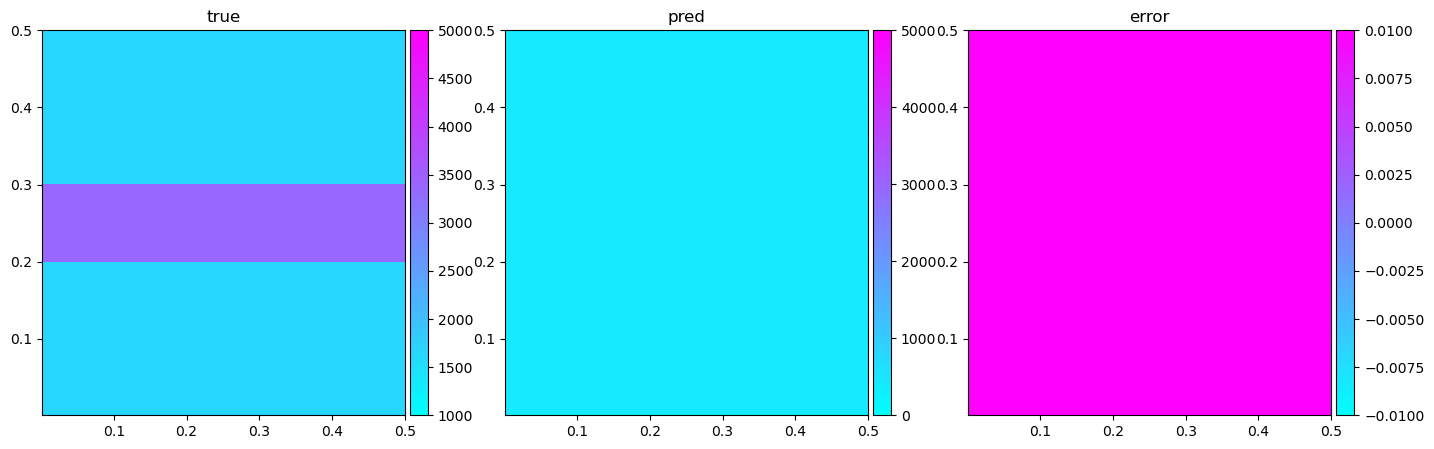

In [12]:
x_test = np.linspace(1.0, 500.0, 500) / x0
z_test = np.linspace(1.0, 500.0, 500) / z0
xz_test = tensor_grid([z_test, x_test])
xz_test[:, [0, 1]] = xz_test[:, [1, 0]]
xz_test_ = xz_test[:, 1:2]

c_pred = inverse_model(tf.constant(xz_test_, dtype = tf.float32), training = False)*c0
def c_func(x, z):
	return np.piecewise(z, [z > 300, (z >= 200) & (z <= 300), z < 200], [1500, 3500, 1500])
c_true = c_func(xz_test[:, 0:1]*x0, xz_test[:, 1:2]*z0)

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = cool
norm = Normalize(vmin=1000, vmax=5000)

X, Z = np.meshgrid(x_test, z_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Z, c_true.reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=0, vmax=5000)
im1 = ax[1].contourf(X, Z, c_pred.numpy().reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, Z, c_true.reshape((len(z_test), len(x_test)))-c_pred.numpy().reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
ax[2].set_title("error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

In [13]:
c_pred

<tf.Tensor: shape=(250000, 1), dtype=float32, numpy=
array([[411.6273],
       [411.6273],
       [411.6273],
       ...,
       [411.6273],
       [411.6273],
       [411.6273]], dtype=float32)>

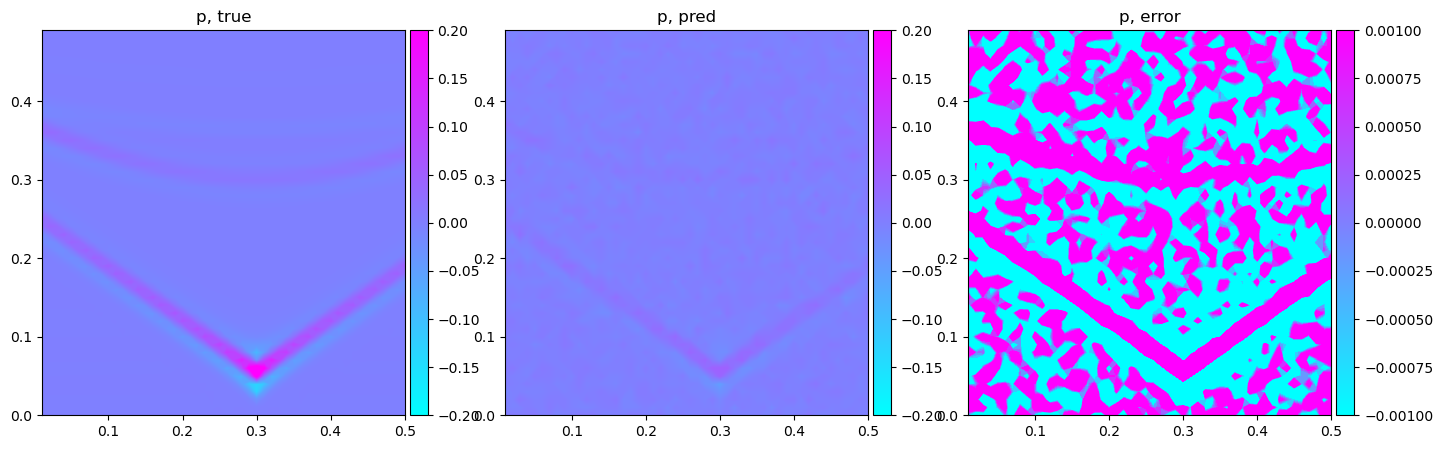

In [10]:
i = 5
p = loadmat("data/sr_{}.mat".format(int(x_s[i]*x0/dx)))["sr_{}".format(int(x_s[i]*x0/dx))]

x_test = np.linspace(10.0, 500.0, 50) / x0
z_test = np.array([10]) / z0
t_test = np.linspace(0.0, 0.49, 50) / t0
xzt_test = tensor_grid([t_test, x_test, z_test])
xzt_test[:, [0, 1, 2]] = xzt_test[:, [1, 2, 0]]

xzts = np.hstack([xzt_test, x_s[i]*np.ones_like(xzt_test[:, 0:1])])
out = direct_model(tf.constant(xzts, dtype = tf.float32))

cmap = cool
norm = Normalize(vmin=-0.2, vmax=0.2)

X, T = np.meshgrid(x_test, t_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, T, p, cmap = cmap, norm = norm, levels = 1000)
ax[0].set_title("p, true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = Normalize(vmin=-0.2, vmax=0.2)
im1 = ax[1].contourf(X, T, out[:, 0:1].numpy().reshape((len(t_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[1].set_title("p, pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-3, vmax=1e-3)
im2 = ax[2].contourf(X, T, p-out[:, 0:1].numpy().reshape((len(t_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[2].set_title("p, error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

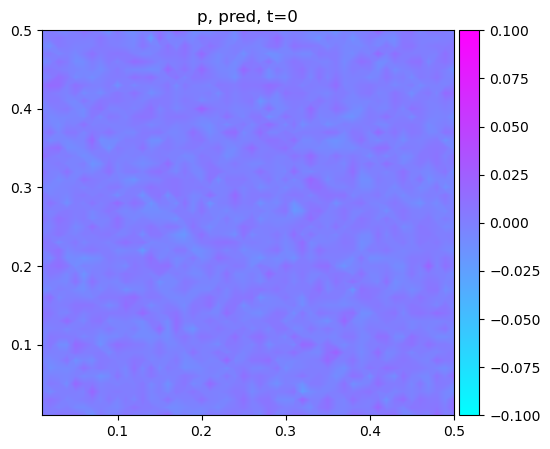

In [11]:
i = 0

x_test = np.linspace(10.0, 500.0, 50) / x0
z_test = np.linspace(10.0, 500.0, 50) / z0
t_test = np.array([0]) / t0
xzt_test = tensor_grid([t_test, x_test, z_test])
xzt_test[:, [0, 1, 2]] = xzt_test[:, [1, 2, 0]]

xzts = np.hstack([xzt_test, x_s[i]*np.ones_like(xzt_test[:, 0:1])])
out = direct_model(tf.constant(xzts, dtype = tf.float32))

cmap = cool
norm = Normalize(vmin=-0.1, vmax=0.1)

X, Z = np.meshgrid(x_test, z_test)
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax.contourf(X, Z, out[:, 0:1].numpy().reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax.set_title("p, pred, t=0")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()